***
# 1. Retrive data from ChEMBL database
***
 

####  We first obtained information about compounds associated with SARS-CoV-2 present in ChEMBL database using this link:

#### [ChEMBL compounds dataset](https://www.ebi.ac.uk/chembl/g/#browse/compounds/filter/_metadata.compound_records.src_id%3A52)

#### Which can be found at ChEMBL main page. 

### a)
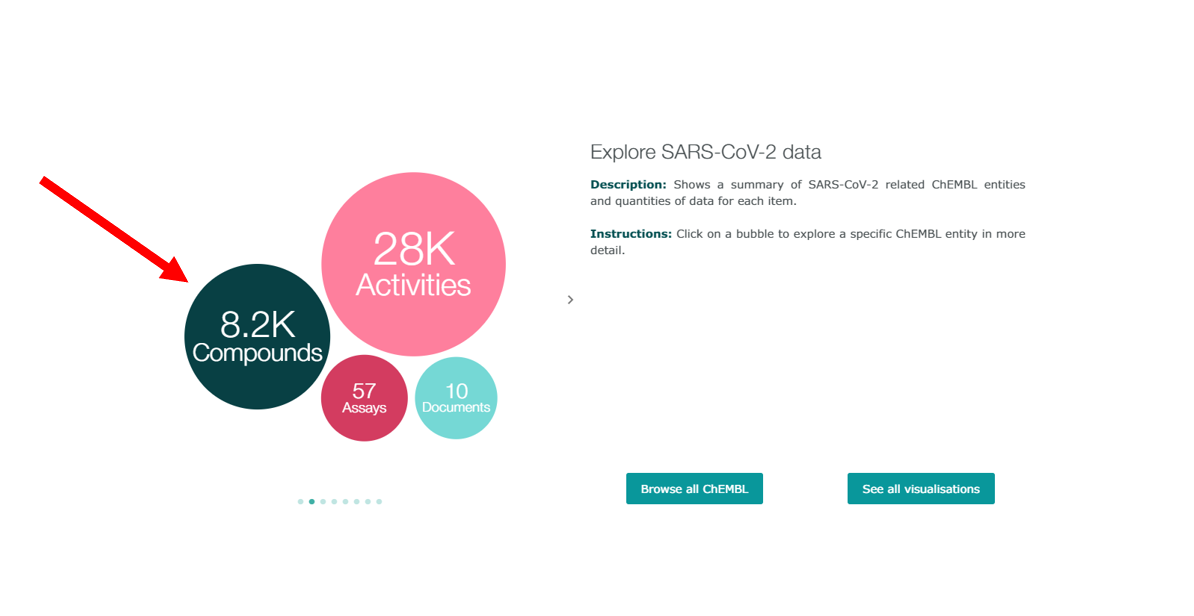




### b)

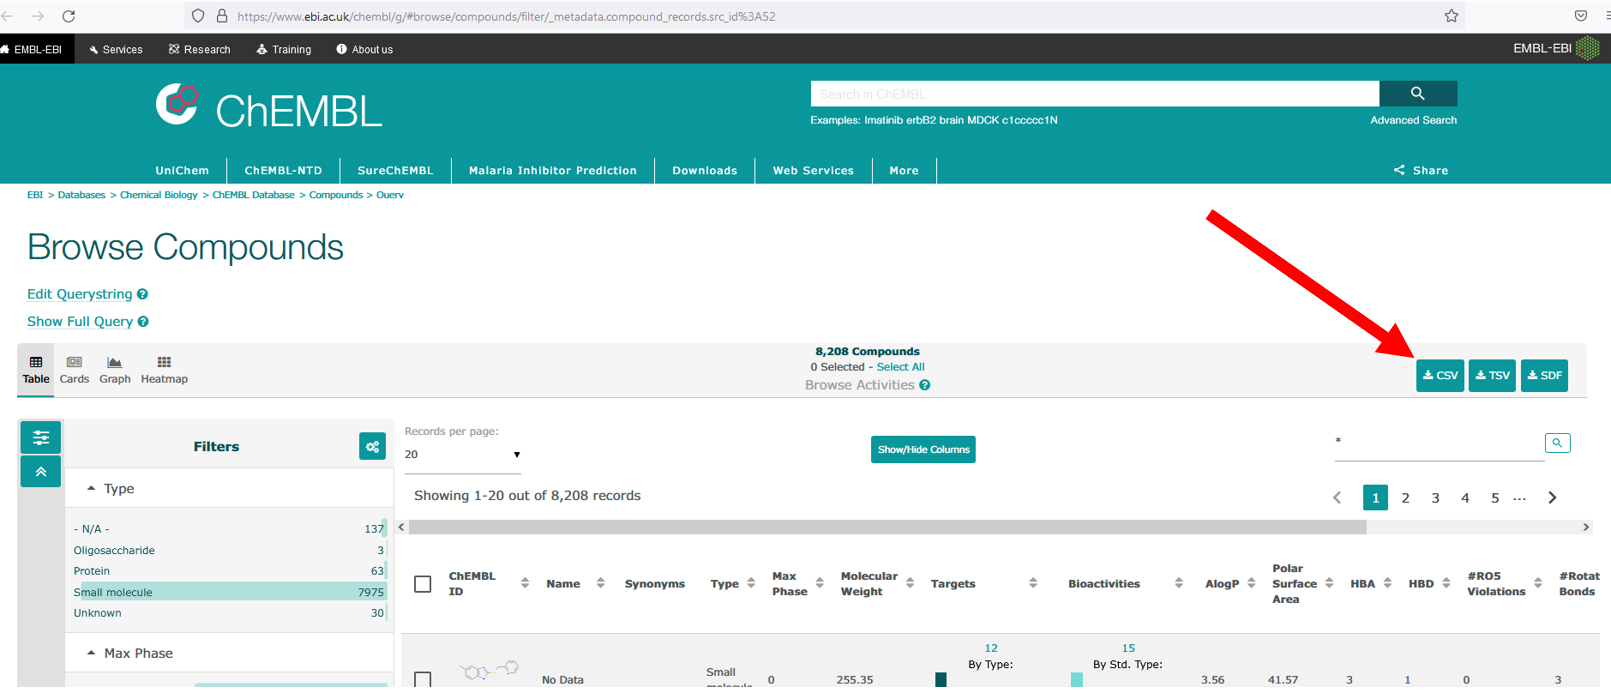

#### After downloading using csv download button , our raw dataset is named chembl_covid_raw.csv.

In [24]:
# imports
import os 
import sys
import json 
import pprint
import pandas as pd 
import numpy as np
from collections import Counter

***
# 2. Filtering by Max Phase and Small Molecule

#### We first filtered out compounds without small molecule targets and without _max phase_, to analyze those drugs at development in phase 1 as a baseline.
***


In [10]:
df = pd.read_csv("chembl_covid_raw.csv", delimiter=";")

print('Compounds associated with SARS-CoV-2: ', df['ChEMBL ID'].nunique())

subset = df.loc[(df['Max Phase'] > 0) & (df['Type'] == "Small molecule")]

cols = ["ChEMBL ID", "Name", "Type", "Max Phase"]

subset = subset[cols]

Compounds associated with SARS-CoV-2:  8208


***
# 3. Retrieve activities for each drugs
***





### We queried information about activities (IC50 and Ki) through cURL on ChEMBL, this process is described in the following images, and can be automatized using a custom bash script.

###  In the "Bioactivities" section, click in the activity of interest, i.e. Ki or IC50.

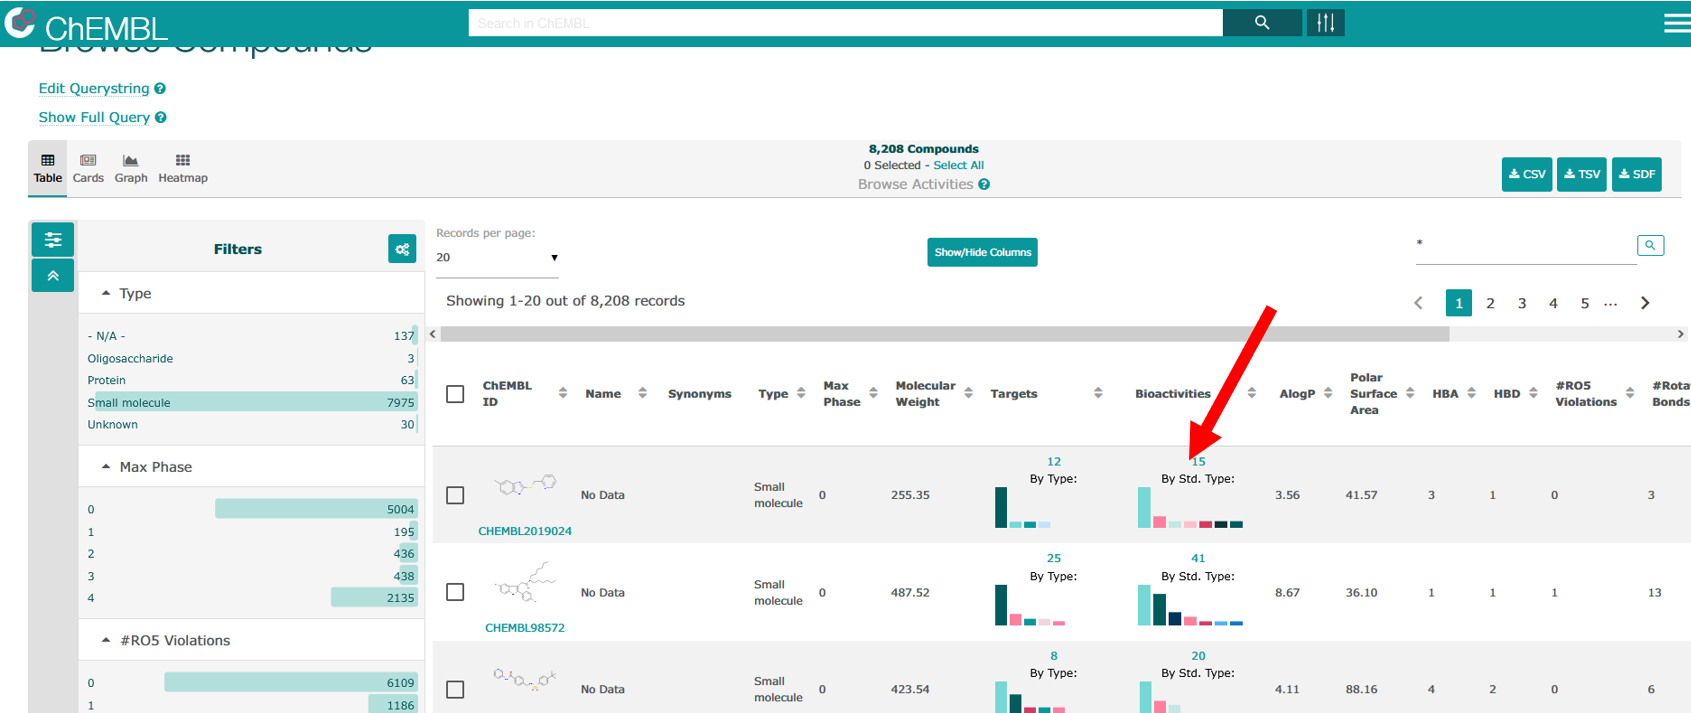
***

### The red arrow indicate where the cURL script can be found, alternatively, the yellow arrow indicate a download button to obtain information about the drug activity for each target.

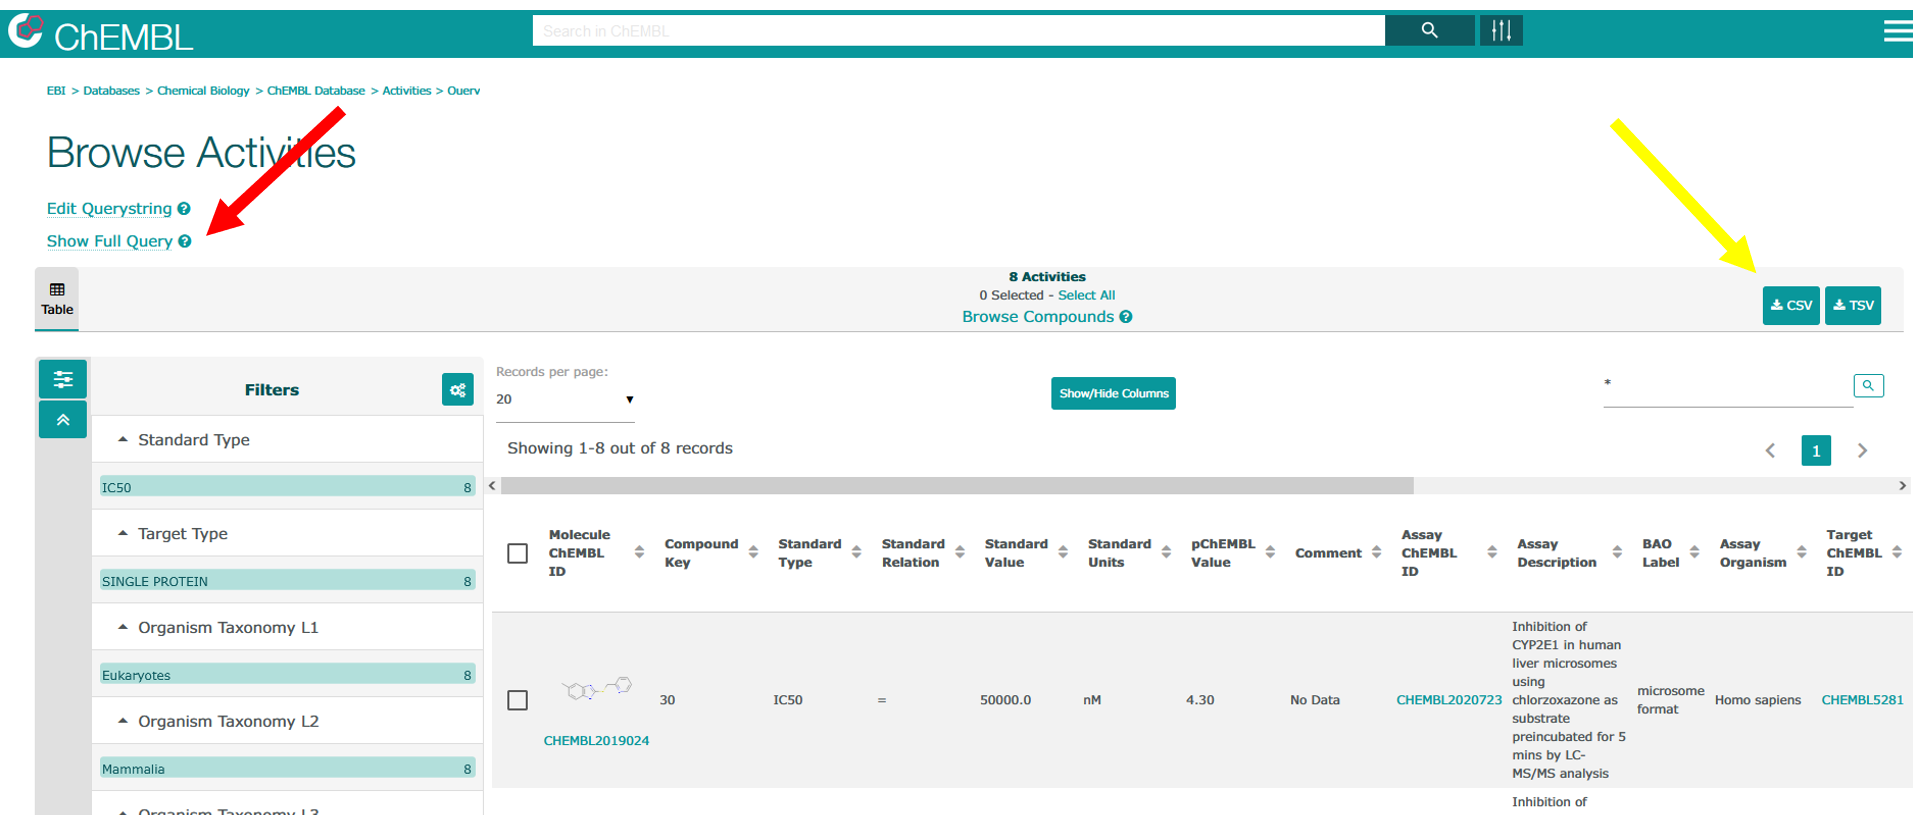

***

### After getting this cURL script, we can generate a query for  each drug to obtain his targets.


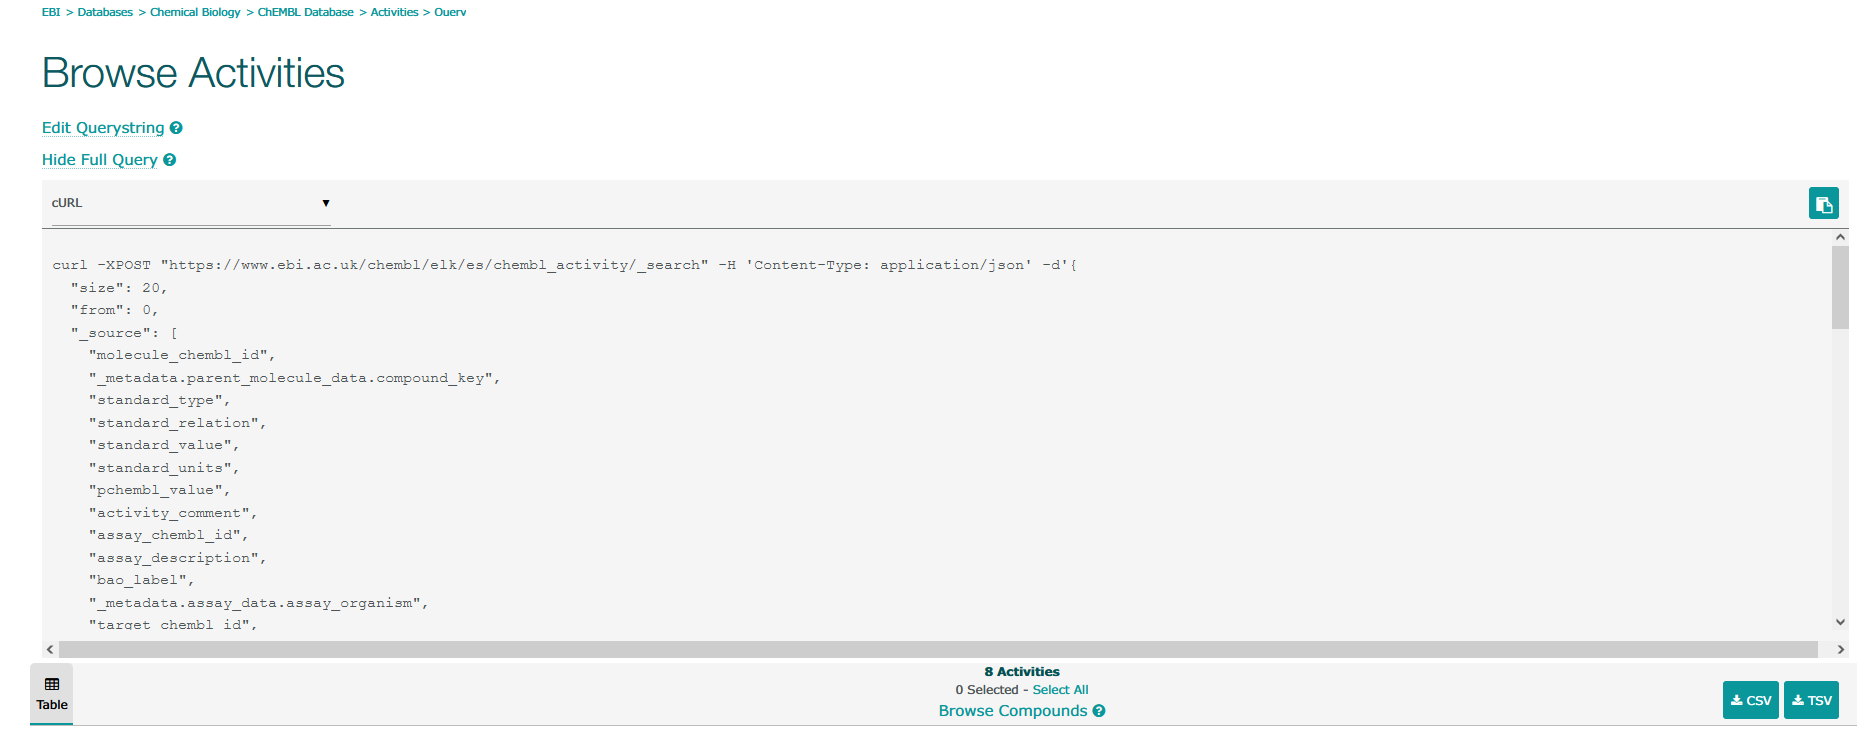

***

### 4. Save the cURL script in a file named chembl_activities.json

### 5. Create folders for json responses


In [1]:
#bash_comand -> mkdir json_files/Ki
#bash_comand -> mkdir json_files/IC50

### 6. Python script to replace each compounds ID and activities, for each drug generated a query file.

In [20]:
activities = ['IC50', 'Ki']
MOD = '"query": "molecule_chembl_id:'
chembl_ids = subset["ChEMBL ID"].tolist()
for compound in chembl_ids:
    for activity in activities:
        with open("json_files/{}_{}.json".format(compound, activity), "w") as g:
            with open("chembl_activities.json") as f:
                for line in f:
                    if MOD in line:
                        print(compound)
                        line = line.replace(MOD, '{}(\\"{}\\") AND standard_type:(\\"{}\\")'.format(MOD, compound, activity))
                        print(line)
                        g.write(line)
                        print(compound, activity)



### 7. Run a bash command where the query files are located to obtain responses files.

In [2]:
#bash_comand -> for f in *.json; do name=`echo $f|cut -d "." -f1`; bash $f > $name.response; done

###  8. After getting each response, we parse those files to obtain activities values and target types (Human, Single Protein).

In [23]:
Ki = "json_files/Ki"

responses = list(f for f in os.listdir(Ki) if f.endswith("response"))
responses = list(os.path.join(Ki, f) for f in responses)

datos = []
for f in responses:
    chembl_id = f.split("/")[-1].split("_")[0]
    data = json.load(open(f)) 
    data = data.get("hits").get("hits")

    for i in data:
        subdict = i
        standard_unit  = subdict.get("_source").get("standard_units")
        if standard_unit != "nM":
            continue
        standard_type  = subdict.get("_source").get("standard_type")
        standard_value = subdict.get("_source").get("standard_value")
        organism       = subdict.get("_source").get("target_organism")
        target_type    = subdict.get("_source").get("_metadata").get("target_data").get("target_type")
        target_chembl_id = subdict.get("_source").get("target_chembl_id")


        if standard_unit not in ["nM", "µM", "ug ml-1", "ng/ml"]:
            continue
        if standard_unit in ["µM", "ug ml-1", "ng/ml"]:
            standard_value = float(standard_value) * 1000

        if not all([standard_unit, standard_type, standard_value, organism, target_type]):
            continue
        
        if target_type != 'SINGLE PROTEIN':
            continue
        if 'coronavirus' not in organism:
            if 'Homo sapiens' not in organism:
                continue

        standard_value = float(standard_value)

        datos.append([chembl_id, standard_type, standard_value, standard_unit, target_chembl_id])

datos = pd.DataFrame(datos, columns=['chembl_id', 'standard_type', 'standard_value', 'standard_unit', 'target_chembl_id'])

print(datos)
print(datos.dtypes)

datos.to_csv("data_Ki.csv")

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #

IC50 = "json_files/IC50"

responses = list(f for f in os.listdir(IC50) if f.endswith("response"))
responses = list(os.path.join(IC50, f) for f in responses)

datos = []
for f in responses:

    chembl_id = f.split("/")[-1].split("_")[0]
    data = json.load(open(f)) 
    data = data.get("hits").get("hits")
    
    for i in data:
        subdict = i

        standard_unit  = subdict.get("_source").get("standard_units")
        if standard_unit != "nM":
            continue
        standard_type  = subdict.get("_source").get("standard_type")
        standard_value = subdict.get("_source").get("standard_value")
        organism       = subdict.get("_source").get("target_organism")
        target_type    = subdict.get("_source").get("_metadata").get("target_data").get("target_type")

        target_chembl_id = subdict.get("_source").get("target_chembl_id")


        if not all([standard_unit, standard_type, standard_value, organism, target_type]):
            continue

        if target_type != 'SINGLE PROTEIN':
            continue
        if 'coronavirus' not in organism:
            if 'Homo sapiens' not in organism:
                continue
        
        standard_value = float(standard_value)

        datos.append([chembl_id, standard_type, standard_value, standard_unit, target_chembl_id])

        

datos = pd.DataFrame(datos, columns=['chembl_id', 'standard_type', 'standard_value', 'standard_unit', 'target_chembl_id'])

print(datos)
print(datos.dtypes)



datos.to_csv("data_IC50.csv")

          chembl_id standard_type  standard_value standard_unit  \
0      CHEMBL100259            Ki      51000.0000            nM   
1      CHEMBL100259            Ki          0.0012            nM   
2      CHEMBL100259            Ki      31000.0000            nM   
3      CHEMBL100259            Ki       5200.0000            nM   
4      CHEMBL100259            Ki     242000.0000            nM   
...             ...           ...             ...           ...   
18170      CHEMBL99            Ki          1.0000            nM   
18171      CHEMBL99            Ki         45.0000            nM   
18172      CHEMBL99            Ki          0.7000            nM   
18173      CHEMBL99            Ki       1400.0000            nM   
18174      CHEMBL99            Ki        800.0000            nM   

      target_chembl_id  
0           CHEMBL1997  
1           CHEMBL4502  
2           CHEMBL5780  
3           CHEMBL5551  
4        CHEMBL3509606  
...                ...  
18170       CHEMBL18